# Importing Important Packages

In [1]:
import cv2 as cv2
from fastai.vision import *
from fastai.basics import *
import shutil
import fire
import matplotlib.pyplot as plt

import skimage
from skimage import io
from skimage.transform import rescale

# Building Execution Functions

In [6]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]

    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)

    def __del__(self): self.hooks.remove()

class SuperResolution():
    def __init__(self, root_path="./"):
        self.model_path = Path(root_path+"model_data")
        self.proba_data = Path(root_path+"probav_data")
        self.test_path_hr = self.proba_data.ls()[2]/'HR_imgs'
        self.test_path_lr = self.proba_data.ls()[2]/'LR_imgs'
        if os.path.exists(str(self.model_path/'export.pkl')):
            print("Building model...")
            self._build_model()
            print("Model build successful!")
        else:
            raise Exception(f"Given root path = {str(self.model_path)} does not contain the export.pkl file!")

    def _build_model(self):
        self.learn = load_learner(self.model_path)

    def save_final_images(self):
        print("Predicting and saving super resolution images for all test data images...")
        for fn in self.test_path_lr.ls():
            img = open_image(fn)
            p,img_hr,b = self.learn.predict(img)
            hr_pred_img = (img_hr.data.cpu().permute(1,2,0).numpy()[..., 1]*65535).astype(np.uint16)
            hr_save_path = str(fn).replace("LR", "HR")
            if not os.path.exists(hr_save_path):
                cv2.imwrite(hr_save_path, hr_pred_img)
        print(f"All test data images passed through model and super resolution images save at {hr_save_path}")

        print("Making submission zip file...")
        self.make_submission_file()
        print(f"Submission zip file saved at {str(self.proba_data.ls()[2])}")

    def make_submission_file(self):
        shutil.make_archive(str(self.proba_data.ls()[2]/"submission"), 'zip', str(self.test_path_hr))

    def save_bi_upsampled_imgs(self):
        for fn in self.test_path_lr.ls():
            mod_img = cv2.imread(str(fn), -1)
            float_img = skimage.img_as_float(mod_img)
            rescaled_img = rescale(float_img, scale=3, order=3, mode='edge', anti_aliasing=False, multichannel=False)
            bi_img = (np.array(rescaled_img)*65535).astype(np.uint16)
            hr_save_path = str(fn).replace("LR", "HR")
            if not os.path.exists(hr_save_path):
                cv2.imwrite(hr_save_path, bi_img)

    def predict_one(self, img_path):
        fn = Path(img_path)
        # get low resolution image
        lr_img = cv2.imread(str(fn), -1)

        # get super resolution image
        img = open_image(fn)
        p,img_hr,b = self.learn.predict(img)
        sr_img = (img_hr.data.cpu().permute(1,2,0).numpy()[..., 1]*65535).astype(np.uint16)

        # Get ground truth HR image
        hr_img = cv2.imread(str(fn).replace("LR", "HR"), -1)

        # Get bi-linear upsampled image
        float_img = skimage.img_as_float(lr_img)
        rescaled_img = rescale(float_img, scale=3, order=3, mode='edge', anti_aliasing=False, multichannel=False)
        bi_img = (np.array(rescaled_img)*65535).astype(np.uint16)

        _, axarr = plt.subplots(2, 2, figsize=(18, 18))
        axarr[0,0].imshow(lr_img)
        axarr[0,0].set_title('Low Resolution Image', fontsize=20, color="white")
        axarr[0,1].imshow(hr_img)
        axarr[0,1].set_title('High Resolution Image', fontsize=20, color="white")
        axarr[1,0].imshow(bi_img)
        axarr[1,0].set_title('Bilinear Upsampled Image', fontsize=20, color="white")
        axarr[1,1].imshow(sr_img)
        axarr[1,1].set_title('Super Resolution Predicted Image', fontsize=20, color="white")
        plt.show()

# Building Model

In [7]:
model = SuperResolution()

Building model...
Model build successful!


# Predicting and making submission file:

In [8]:
model.save_final_images()

Predicting and saving super resolution images for all test data images...
All test data images passed through model and super resolution images save at probav_data/test/HR_imgs/imgset1240.png
Making submission zip file...
Submission zip file saved at probav_data/test


# Predicting on single Images:

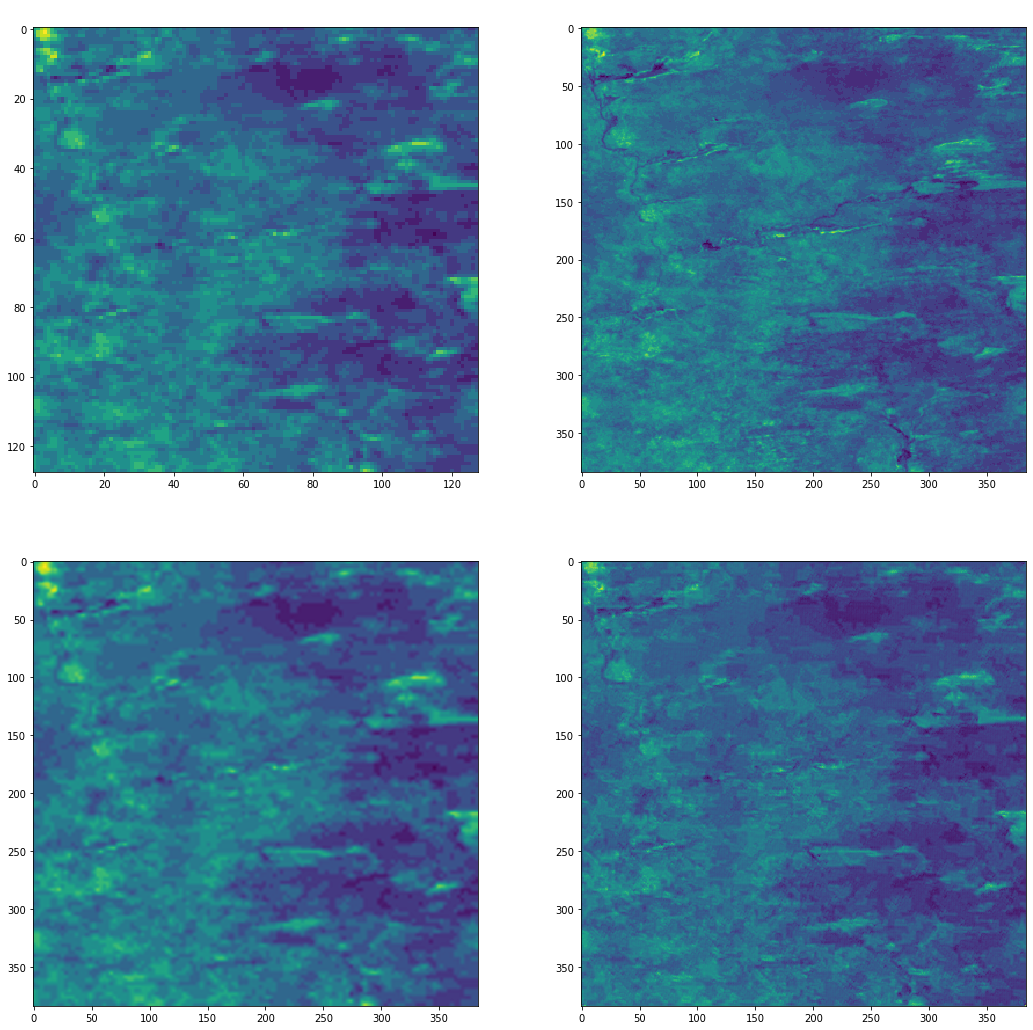

In [9]:
# Change the Index or Change the path itself to predict on new images:
idx = "0000"
model.predict_one(img_path=f"./probav_data/train/LR_imgs/imgset{idx}.png")